# Generate molecules with a GNN diffusion model

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from pathlib import Path

from diffusion_gnn_2d.models import create_diffusion_model, create_noise_scheduler
from diffusion_gnn_2d.data.deepchem import DeepChemMolecularDataset
from diffusion_gnn_2d.utils.generation import sample_from_model, features_to_atom_types
from diffusion_gnn_2d.utils.molecule_conversion import create_simple_molecule, validate_smiles, calculate_molecular_properties
from diffusion_gnn_2d.utils.metrics import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [10]:
# Load trained model
dataset = DeepChemMolecularDataset('tox21', max_atoms=30)
atom_dim = dataset._get_atom_feature_dim()
bond_dim = dataset._get_bond_feature_dim()

print(f"Dataset loaded: {len(dataset.dataset)} molecules")
print(f"Atom dim: {atom_dim}, Bond dim: {bond_dim}")

INFO:diffusion_gnn_2d.data.deepchem:Loading DeepChem dataset: tox21
INFO:deepchem.data.datasets:Loading dataset from disk.
INFO:deepchem.data.datasets:Loading dataset from disk.
INFO:deepchem.data.datasets:Loading dataset from disk.
INFO:diffusion_gnn_2d.data.deepchem:Loaded tox21 dataset with 6258 molecules


Dataset loaded: 6258 molecules
Atom dim: 37, Bond dim: 10


In [12]:
def load_trained_model(checkpoint_dir='../results', device='cuda'):
    """Load trained model with proper fallbacks for independent execution"""
    from pathlib import Path

    checkpoint_path = Path(checkpoint_dir) / 'best_molecular_diffusion.pt'

    if not checkpoint_path.exists():
        raise FileNotFoundError(f"No checkpoint found at {checkpoint_path}")

    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

    # Get model config from checkpoint, or use safe defaults
    model_config = checkpoint.get('model_config')

    if model_config is None:
        # Create independent fallback config
        print("⚠️ No model config in checkpoint, using defaults")

        # Load dataset to get feature dimensions
        from diffusion_gnn_2d.data.deepchem import DeepChemMolecularDataset
        dataset = DeepChemMolecularDataset('tox21', max_atoms=30)

        model_config = {
            'atom_dim': dataset._get_atom_feature_dim(),
            'bond_dim': dataset._get_bond_feature_dim(),
            'hidden_dim': 128,
            'num_layers': 3,
            'gnn_type': 'gat'  # Default to GAT
        }
        print(f"Using config: {model_config}")

    model = create_diffusion_model(**model_config).to(device)
    scheduler = create_noise_scheduler(num_timesteps=200).to(device)

    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    print(f"Loaded model from epoch {checkpoint['epoch']+1}, loss: {checkpoint['loss']:.6f}")
    return model, scheduler

# Load model independently
try:
    model, scheduler = load_trained_model(checkpoint_dir='../results', device=device)
    print("✅ Using pre-trained model for generation!")

except FileNotFoundError:
    print("❌ No pre-trained model found. Creating default model...")

    # Load dataset for feature dimensions
    from diffusion_gnn_2d.data.deepchem import DeepChemMolecularDataset
    dataset = DeepChemMolecularDataset('tox21', max_atoms=30)

    model = create_diffusion_model(
        atom_dim=dataset._get_atom_feature_dim(),
        bond_dim=dataset._get_bond_feature_dim(),
        hidden_dim=128,
        num_layers=3,
        gnn_type='gat'  # Default choice
    ).to(device)

    scheduler = create_noise_scheduler(num_timesteps=200).to(device)
    print("✅ Created new GAT model for generation!")

print("🚀 Model ready for generation!")

Loaded model from epoch 4, loss: 0.117919
✅ Using pre-trained model for generation!
🚀 Model ready for generation!


In [13]:
# Generate molecular features
print("Generating molecules...")
generated_features = sample_from_model(
    model, scheduler,
    num_molecules=100,
    max_atoms=15,
    atom_dim=atom_dim,
    bond_dim=bond_dim,
    device=device
)

print(f"Generated features shape: {generated_features.shape}")

# Get generated atomic elements and convert to SMILES
generated_smiles = []
for mol_idx in range(generated_features.shape[0]):
    mol_features = generated_features[mol_idx]
    atom_types = features_to_atom_types(mol_features)
    print(f"Molecule {mol_idx+1}: {atom_types}")

    # convert to SMILES
    smiles = create_simple_molecule(atom_types)
    if smiles:
        generated_smiles.append(smiles)
        print(f"  -> SMILES: {smiles}")

print(f"\nGenerated {len(generated_smiles)} valid SMILES out of {generated_features.shape[0]} molecules")


Generating molecules...
Generated features shape: torch.Size([100, 15, 37])
Molecule 1: ['H', 'H', 'C', 'S', 'C', 'C', 'C', 'C', 'C', 'F', 'I', 'N', 'Other', 'O', 'P']
  -> SMILES: CCO
Molecule 2: ['C', 'H', 'Cl', 'N', 'Br', 'H', 'N', 'P', 'C', 'H', 'N', 'H', 'C', 'C', 'C']
  -> SMILES: CCN
Molecule 3: ['O', 'Other', 'C', 'C', 'C', 'I', 'C', 'C', 'O', 'H', 'Other', 'I', 'C', 'I', 'C']
  -> SMILES: CCO
Molecule 4: ['C', 'N', 'O', 'O', 'I', 'N', 'C', 'C', 'C', 'I', 'O', 'N', 'N', 'O', 'O']
  -> SMILES: CCO
Molecule 5: ['C', 'C', 'N', 'P', 'H', 'C', 'N', 'P', 'C', 'C', 'H', 'Other', 'C', 'P', 'Cl']
  -> SMILES: CCN
Molecule 6: ['O', 'C', 'O', 'C', 'O', 'C', 'N', 'O', 'H', 'P', 'O', 'O', 'O', 'Other', 'N']
  -> SMILES: CCO
Molecule 7: ['C', 'C', 'Cl', 'C', 'F', 'C', 'P', 'C', 'C', 'C', 'I', 'I', 'N', 'C', 'C']
  -> SMILES: CCN
Molecule 8: ['C', 'O', 'O', 'N', 'C', 'P', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O']
  -> SMILES: CCO
Molecule 9: ['N', 'P', 'Br', 'C', 'O', 'H', 'O', 'N', 'O', '

INFO:diffusion_gnn_2d.data.deepchem:Converting 6258 molecules to graphs...
INFO:diffusion_gnn_2d.data.deepchem:Processed 0/6258 molecules...
[19:58:57] WARNING: not removing hydrogen atom without neighbors
INFO:diffusion_gnn_2d.data.deepchem:Processed 1000/6258 molecules...
INFO:diffusion_gnn_2d.data.deepchem:Processed 2000/6258 molecules...
INFO:diffusion_gnn_2d.data.deepchem:Processed 3000/6258 molecules...
INFO:diffusion_gnn_2d.data.deepchem:Processed 4000/6258 molecules...
INFO:diffusion_gnn_2d.data.deepchem:Processed 5000/6258 molecules...
INFO:diffusion_gnn_2d.data.deepchem:Processed 6000/6258 molecules...
INFO:diffusion_gnn_2d.data.deepchem:Successfully converted 5856/6258 molecules (93.6%)
INFO:diffusion_gnn_2d.data.deepchem:Failed conversions: 402
/home/jantine/miniconda3/envs/diff_gnn/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


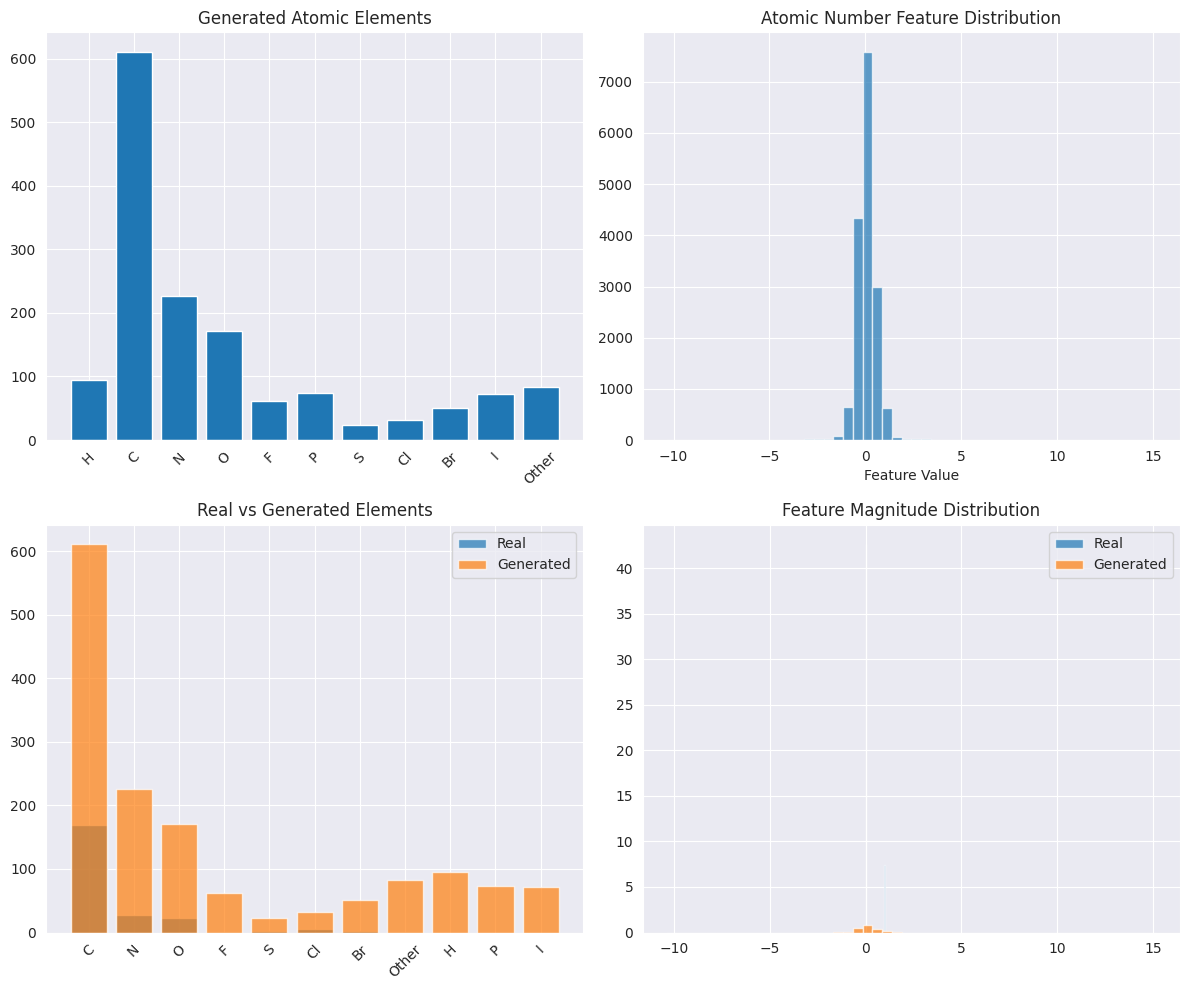

In [14]:
# Visualize feature distributions
def plot_generation_analysis(features, dataset):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Atomic element distribution
    all_features = features.reshape(-1, features.shape[-1])
    atomic_probs = torch.softmax(all_features[:, :11], dim=1)
    predicted_elements = torch.argmax(atomic_probs, dim=1)

    elements = ['H', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I', 'Other']
    unique_elements, counts = torch.unique(predicted_elements, return_counts=True)

    element_names = [elements[i] for i in unique_elements.cpu()]
    axes[0,0].bar(element_names, counts.cpu().numpy())
    axes[0,0].set_title('Generated Atomic Elements')
    axes[0,0].tick_params(axis='x', rotation=45)

    # Feature value distributions
    axes[0,1].hist(all_features[:, :11].cpu().numpy().flatten(), bins=50, alpha=0.7)
    axes[0,1].set_title('Atomic Number Feature Distribution')
    axes[0,1].set_xlabel('Feature Value')

    # Compare with real data sample
    real_batch = next(iter(dataset.create_dataloader(batch_size=16)))
    real_elements = torch.argmax(real_batch.x[:, :11], dim=1)
    real_unique, real_counts = torch.unique(real_elements, return_counts=True)

    axes[1,0].bar([elements[i] for i in real_unique.cpu()], real_counts.cpu().numpy(), alpha=0.7, label='Real')
    axes[1,0].bar(element_names, counts.cpu().numpy(), alpha=0.7, label='Generated')
    axes[1,0].set_title('Real vs Generated Elements')
    axes[1,0].legend()
    axes[1,0].tick_params(axis='x', rotation=45)

    # Feature magnitude comparison
    axes[1,1].hist(real_batch.x.cpu().numpy().flatten(), bins=50, alpha=0.7, label='Real', density=True)
    axes[1,1].hist(all_features.cpu().numpy().flatten(), bins=50, alpha=0.7, label='Generated', density=True)
    axes[1,1].set_title('Feature Magnitude Distribution')
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()

plot_generation_analysis(generated_features, dataset)

In [15]:
# Validation metrics of SMILES

# Get training SMILES for novelty calculation
training_smiles = [dataset.dataset.ids[i] for i in range(min(1000, len(dataset.dataset)))]
valid_training = [smi for smi in training_smiles if validate_smiles(smi)]

# Calculate metrics
validity = calculate_validity_rate(generated_smiles)
uniqueness = calculate_uniqueness_rate(generated_smiles)
novelty = calculate_novelty_rate(generated_smiles, valid_training)
diversity_metrics = calculate_diversity_metrics(generated_smiles)

print(f"Validity: {validity:.2f}")
print(f"Uniqueness: {uniqueness:.2f}")
print(f"Novelty: {novelty:.2f}")
print(f"Diversity Metrics: {diversity_metrics}")


Validity: 1.00
Uniqueness: 0.04
Novelty: 0.75
Diversity Metrics: {'diversity': 0.14250505050505757, 'scaffold_diversity': 0.14250505050505757}


[19:59:16] WARNING: not removing hydrogen atom without neighbors


In [16]:
# Property analysis
valid_generated = [smi for smi in generated_smiles if validate_smiles(smi)]
print(f"\nValid molcules: {len(valid_generated)} out of {len(generated_smiles)}")

if valid_generated:
    properties = [calculate_molecular_properties(smi) for smi in valid_generated[:20]]
    prop_df = pd.DataFrame(properties)
    print("\nGenerated Molecular Properties:")
    print(prop_df.describe())


Valid molcules: 100 out of 100

Generated Molecular Properties:
       molecular_weight       logp      tpsa  num_atoms  num_bonds  \
count         20.000000  20.000000  20.00000  20.000000  20.000000   
mean          45.072450  -0.030985  21.96700   2.950000   1.950000   
std            3.100968   0.086282   2.72224   0.223607   0.223607   
min           32.042000  -0.391500  20.23000   2.000000   1.000000   
25%           45.085000  -0.035000  20.23000   3.000000   2.000000   
50%           46.069000  -0.001400  20.23000   3.000000   2.000000   
75%           46.069000  -0.001400  26.02000   3.000000   2.000000   
max           46.069000  -0.001400  26.02000   3.000000   2.000000   

       rotatable_bonds  
count             20.0  
mean               0.0  
std                0.0  
min                0.0  
25%                0.0  
50%                0.0  
75%                0.0  
max                0.0  


[19:59:16] WARNING: not removing hydrogen atom without neighbors
[19:59:16] WARNING: not removing hydrogen atom without neighbors


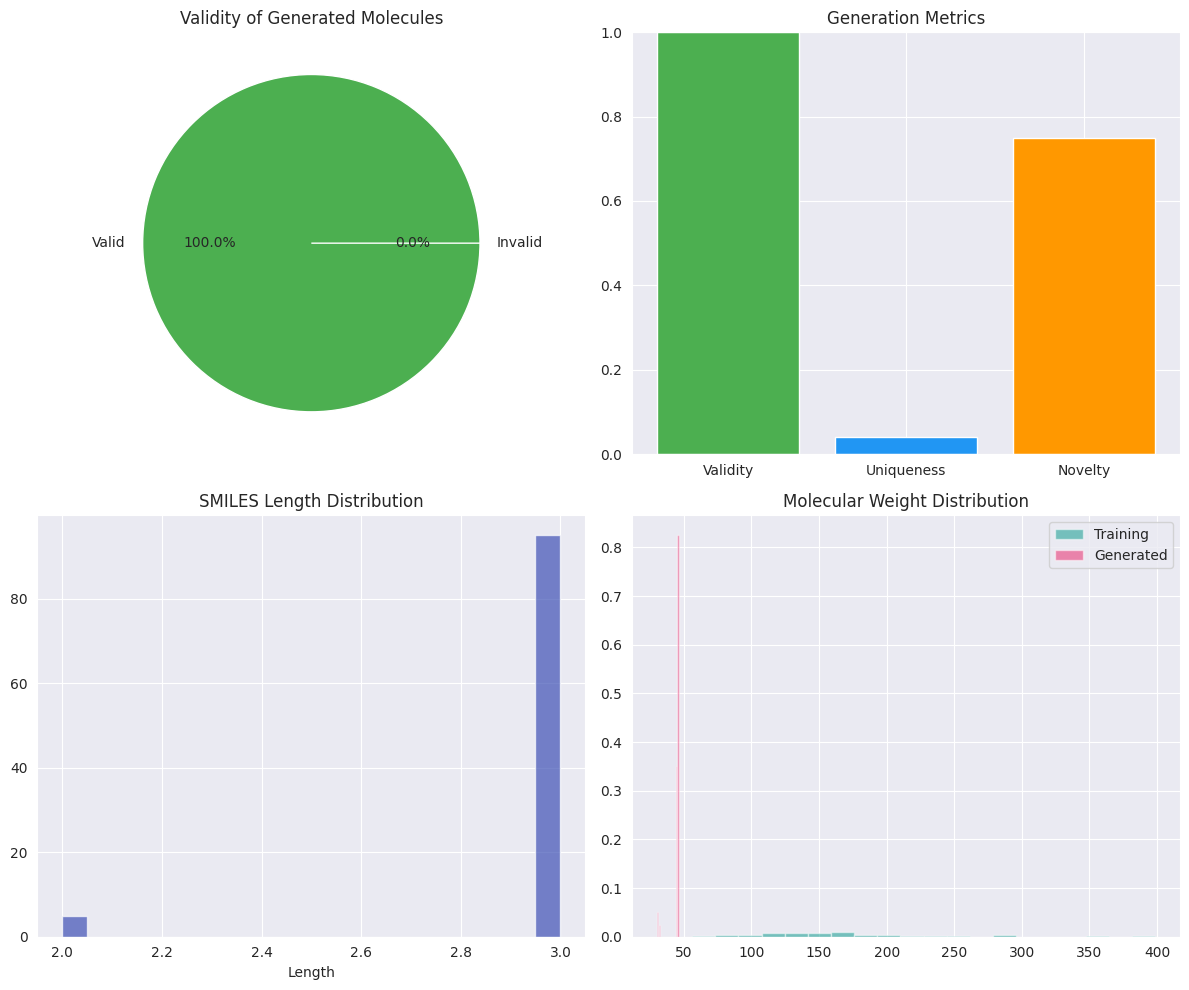

In [17]:
#visualise
def create_validation_dashboard(generated_smiles, training_smiles):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Validity Pie Chart
    valid_count = sum(1 for smi in generated_smiles if validate_smiles(smi))
    invalid_count = len(generated_smiles) - valid_count

    axes[0,0].pie([valid_count, invalid_count], labels=['Valid', 'Invalid'], autopct='%1.1f%%', colors=['#4CAF50', '#FF5722'])
    axes[0,0].set_title('Validity of Generated Molecules')

    # Metrics bar chart
    validity = valid_count / len(generated_smiles)
    uniqueness = calculate_uniqueness_rate(generated_smiles)
    novelty = calculate_novelty_rate(generated_smiles, training_smiles)

    metrics = ["Validity", "Uniqueness", "Novelty"]
    values = [validity, uniqueness, novelty]
    axes[0,1].bar(metrics, values, color=['#4CAF50', '#2196F3', '#FF9800'])
    axes[0,1].set_ylim(0, 1)
    axes[0,1].set_title('Generation Metrics')

    # SMILES length distribution
    lengths = [len(smi) for smi in generated_smiles]
    axes[1,0].hist(lengths, bins=20, color='#3F51B5', alpha=0.7)
    axes[1,0].set_title('SMILES Length Distribution')
    axes[1,0].set_xlabel('Length')

    # Property comparison (if RDKit works)
    try:
        valid_gen = [smi for smi in generated_smiles if validate_smiles(smi)]
        if valid_gen:
            gen_props = [calculate_molecular_properties(smi) for smi in valid_gen[:50]]
            train_props = [calculate_molecular_properties(smi) for smi in training_smiles[:50] if validate_smiles(smi)]

            gen_mw = [p["molecular_weight"] for p in gen_props if p]
            train_mw = [p["molecular_weight"] for p in train_props if p]

            axes[1,1].hist(train_mw, alpha=0.5, label='Training', bins=20, color='#009688', density=True)
            axes[1,1].hist(gen_mw, alpha=0.5, label='Generated', bins=20, color='#E91E63', density=True)
            axes[1,1].set_title('Molecular Weight Distribution')
            axes[1,1].legend()
    except Exception as e:
        axes[1,1].text(0.5, 0.5, 'RDKit not available', horizontalalignment='center', verticalalignment='center')

    plt.tight_layout()
    plt.show()

create_validation_dashboard(generated_smiles, training_smiles)